# Notebook for the 2021 Building Simulation conference 
- **Study context** : This notebook presents a dwelling PV self-consumption use case from an early stage design perspective. First we carry out a two-objective optimisation in order to maximise the coverage of local consumption by photovoltaic electricity on the one hand, and to minimise the environmental impact of the energy system over its entire life cycle on the other hand.
The study focuses on one single representative building with PV panels and battery storage within the framework of a self-consumption operation. At the moment, it does not explore other relevant means to improve self-consumption rates, such as Demand Side Management, or other storage technologies ranging from other battery chemistries, to hydrogen for inter-seasonal storage, to heat storage.  
An optimal power flow management is applied to the obtained energy system design. This second part of the study is detailed hereinafter.  
- **Licence** : [Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0.html), Copyright 2018 G2Elab / MAGE*
- **References** : [Open and Reproducible Use Cases in the Energy field for systems design and operation: a dwelling photovoltaic self-consumption example](https://hal.archives-ouvertes.fr/hal-03341883)
- **Tool** : [OMEGAlpes](https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes), version 0.4.0, licence Apache 2.0. It is a linear optimization tool designed to easily generate multi-carrier energy system models.  
- Link to other related use cases :
   - The first part of the study uses the free and open source software [NoLOAD](https://gricad-gitlab.univ-grenoble-alpes.fr/design_optimization/noload), and is describded in the following [notebook](https://gricad-gitlab.univ-grenoble-alpes.fr/design_optimization/noload_benchmarks_open/-/blob/master/examples/pv_battery_coverage_gwp/pv_battery_coverage_gwp.ipynb).
- **Developer - institution** : Sacha Hodencq (sacha.hodencq@g2elab.grenoble-inp.fr) - G2Elab   
- [Factsheet](#factsheet) available in the end of this notebook.  

>***First time using a Jupyter Notebook ?*** In order to use this notebook online through the Mybinder public service, click the following icon  
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fomegalpes%2Fomegalpes_examples/HEAD?filepath=%2Fnotebooks%2Farticle_2021_BS_ORUCE.ipynb)  

>You can then easily use this Jupyter notebook by runnning each cell with the Run ("Exécuter" in French) icon in the toolbar on top of the page. When the orange notebook icon in the tab turns into an hourglass, this means the code is still running. Do not hesitate to modify and adapt the code, working with Mybinder creates an online copy of the repository ipynb original file.

## Relevant libraries imports

We first import relevant modules through a python script

In [1]:
%matplotlib notebook
##########################################################################################
## Code to execute if you are working on mybinder (remove '#' hereunder)
# import os
# os.system('pip install -r specific_requirements/article_2021_BS_ORUCE_requirements.txt')

## If not, we suggest you to use Anaconda and install these same requirements before 
## running this notebook.
##########################################################################################

import pulp

from pulp import LpStatus

import numpy as np
import pandas as pd
from python_scripts.NB_ORUCE_utils import *
from omegalpes.general.optimisation.elements import Objective

## Irradiance & consumption profiles
The irradiance and consumption profiles can be adapted depending on the location or consumers' specificities.  
In this study, we take irradiance profiles from Grenoble :
- DHI : Diffuse Horizontal Irradiation (W/m²)
- DNI : Direct Normal Irradiation (W/m²)   

Irradiance (based on the [OEMetadata](https://github.com/OpenEnergyPlatform/oemetadata/blob/develop/metadata/latest/metadata_key_description.md)) : 

|#|Key |Parameter |
|---|---|---|
| 1 | name |irradiance_data.csv| 
| 2 | title | Irradiance data in Grenoble in 2019| 
| 3 | id | |
| 4 | description | Irradiance data in Grenoble including the DHI and DNI |
| 5 | language | |
| 6 | subject |  |
| 7 | keywords | |
| 8 | publicationDate |2020 |
| 9 | context | |
| 10 | spatial |Grenoble, 21 avenue des Martyrs| 
| 11 | temporal | 2019, hourly time step|
| 12 | source |http://mhi-srv.g2elab.grenoble-inp.fr/API/ |
| 13 | licenses | Public Domain Dedication and License version v1.0. |
| 14 | contributors | Delinchant B. and Laranjeira T. |
| 15 | resources |Delinchant B., Wurtz F., Ploix S., Schanen J.-L. and Marechal Y. (2016). "GreEn-ER Living Lab - A Green Building with Energy Aware Occupants". SmartGreen'16, In proceedings of the 5th International Conference on Smart Cities and Green ICT Systems. ISBN 978-989-758-184-7, pages 316-323. DOI: 10.5220/0005795303160323 |
These irradiance data sets come from the GreEn-Er (G2Elab and ENSE3 school building) [weather station](https://g2elab-shiny.g2elab.grenoble-inp.fr/meteo-greener/).  

Typical consumption profiles for French households are also considered:
- consumption : time vector of power consumption coming from Enedis (French DSO), [RES1 profile](https://www.enedis.fr/coefficients-des-profils "RES1 profiles on Enedis website") i.e. consumption profiles for dwellings connected in low-voltage with nominal power lower than 6 kVA. We apply an annual consumption of 4586 kWh per year and per dwelling to this RES1 profile.  

|#|Key |Parameter |
|---|---|---|
| 1 | name | consumption_data.csv|
| 2 | title |RES1 data| 
| 3 | id | |
| 4 | description | Data for typical residential load profiles in France in 2019 |
| 5 | language | |
| 6 | subject |  |
| 7 | keywords | |
| 8 | publicationDate | 2020|
| 9 | context | |
| 10 | spatial |France, residential scale| 
| 11 | temporal | 2019, hourly time step|
| 12 | source |https://data.enedis.fr/pages/coefficients-des-profils/ |
| 13 | licenses |  Licence ouverte v2.0 (Etalab) |
| 14 | contributors | [Enedis](https://data.enedis.fr/pages/accueil) |
| 15 | resources |[Enedis Open data](https://www.enedis.fr/open-data) |

The *irradiance_and_consumption_data.csv* csv file have been obtained from open data bases. To access the data processing used to get it, please refer to the [notebook](https://gricad-gitlab.univ-grenoble-alpes.fr/design_optimization/noload_benchmarks_open/-/blob/master/examples/pv_battery_coverage_gwp/pv_battery_coverage_gwp.ipynb) presenting the first part of the study. 

In [2]:
# Data
yearly_data = read_data(file_name='./data/irradiance_and_consumption_data.csv')
yearly_irradiance = yearly_data[0]
yearly_consumption = yearly_data[1]
print(yearly_data)

(                       DHI  DNI
TIMESTAMP                      
2019-01-01 00:00:00  0.560  0.0
2019-01-01 01:00:00  0.571  0.0
2019-01-01 02:00:00  0.431  0.0
2019-01-01 03:00:00  0.540  0.0
2019-01-01 04:00:00  0.559  0.0
...                    ...  ...
2019-12-31 19:00:00  6.303  0.0
2019-12-31 20:00:00  6.300  0.0
2019-12-31 21:00:00  6.160  0.0
2019-12-31 22:00:00  6.266  0.0
2019-12-31 23:00:00  6.214  0.0

[8760 rows x 2 columns],                      consumption
TIMESTAMP                       
2019-01-01 00:00:00   551.728193
2019-01-01 01:00:00   495.551939
2019-01-01 02:00:00   459.914379
2019-01-01 03:00:00   423.767507
2019-01-01 04:00:00   395.801003
...                          ...
2019-12-31 19:00:00   926.918205
2019-12-31 20:00:00   863.540169
2019-12-31 21:00:00   768.804806
2019-12-31 22:00:00   672.317364
2019-12-31 23:00:00   600.213590

[8760 rows x 1 columns])


## PV power calculation
The following part enables to choose the PV pannels parameters. The PV self-consumption energy system here consists in PV pannels and lead acid batteries, and is sized in order to get a compromise between PV coverage and low environmental impact on the whole life cycle : it is based on the first part of the study mentionned on the top of this notebook. In the end, this compromise depends on the user’s choice. The following sizing is arbitrarily chosen as the energy system sizing: a PV panel surface area of 12.2 m² with a tilt of 25.4° and an azimuth of 23.8°, but it can be changed.

In [3]:
# A PV power profile example...
tilt = 25.4
azimuth = 23.8
surface = 12.2

In [4]:
# Using date index in order to determine the sun trajectory
solar = PVSolar(yearly_irradiance.index.to_series())  

yearly_DNI = np.array(yearly_irradiance['DNI'])
yearly_DHI = np.array(yearly_irradiance['DHI'])

# determining pv_power and energy from the given parameters, DNI and DHI:
yearly_pv_power_values = solar.pv_power(tilt, azimuth, surface, yearly_DNI, yearly_DHI)  
yearly_pv_power = pd.DataFrame({'pv_power': yearly_pv_power_values}, index = yearly_consumption.index)
pv_energy = solar.pv_energy(tilt, azimuth, surface, yearly_DNI, yearly_DHI)

yearly_cons_values = yearly_consumption.values[:, 0]

<IPython.core.display.Javascript object>


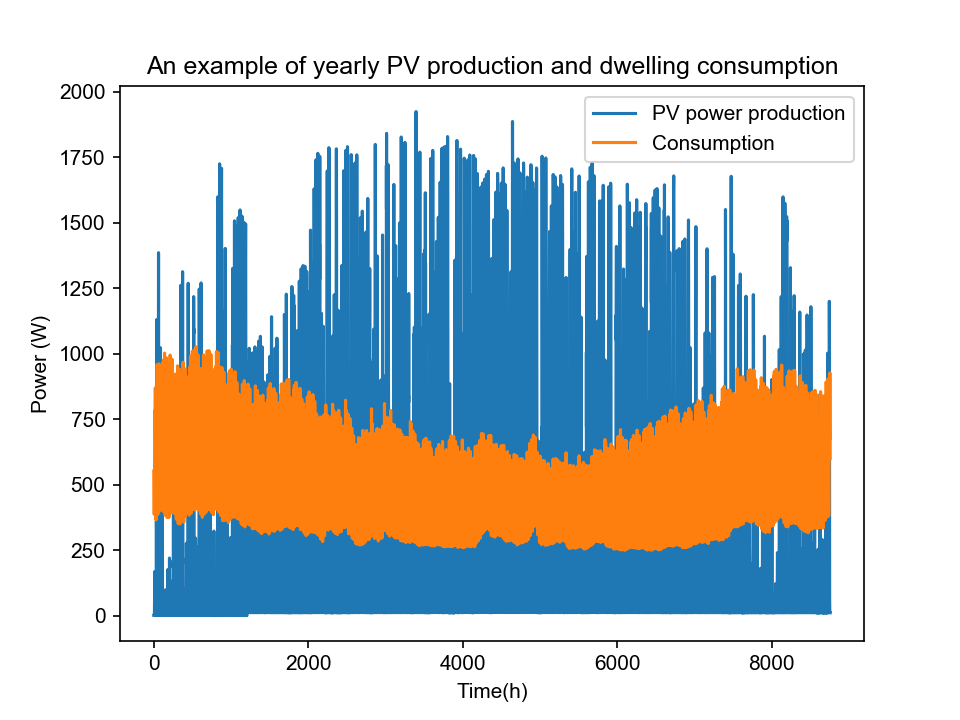

Annual consumption of a single dwelling= 4453 kWh
Annual production of the PV pannels with the given parameters= 2650 kWh


In [5]:
# plot
fig2, ax2 = plt.subplots()  
ax2.plot(yearly_pv_power_values, label='PV power production') 
ax2.plot(yearly_cons_values, label='Consumption') 
ax2.set_xlabel('Time(h)')  
ax2.set_ylabel('Power (W)')  
ax2.set_title('An example of yearly PV production and dwelling consumption')
ax2.legend()  
print('Annual consumption of a single dwelling= {} kWh'.format(round(sum(yearly_cons_values)/1e3)))
print('Annual production of the PV pannels with the given parameters= {} kWh'.format(round(pv_energy)))

## Time management
With open source solvers such as CBC, the default solver used with [PuLP](https://pypi.org/project/PuLP/) in OMEGAlpes, consider studying periods below a season in time length (i.e. 3 months). A season will be solved in about 5 minutes. Performances will be enhanced with solvers such as Gurobi or Cplex.  
Taking these limitations into account, the following part enables to choose the dates on which the study is carried out depending on users preferences.

In [6]:
start_date = '26/08/2019 00:00'
end_date = '30/08/2019 23:00'  
consumption = yearly_consumption.loc[pd.to_datetime(start_date):pd.to_datetime(end_date)]
pv_power = yearly_pv_power.loc[pd.to_datetime(start_date):pd.to_datetime(end_date)]
time = TimeUnit(start=start_date, end = end_date, dt=1)

cons_values = consumption.values[:, 0]
pv_power_values = pv_power.values[:, 0]

You are studying the period from 2019-08-26 00:00:00 to 2019-08-30 23:00:00


<IPython.core.display.Javascript object>


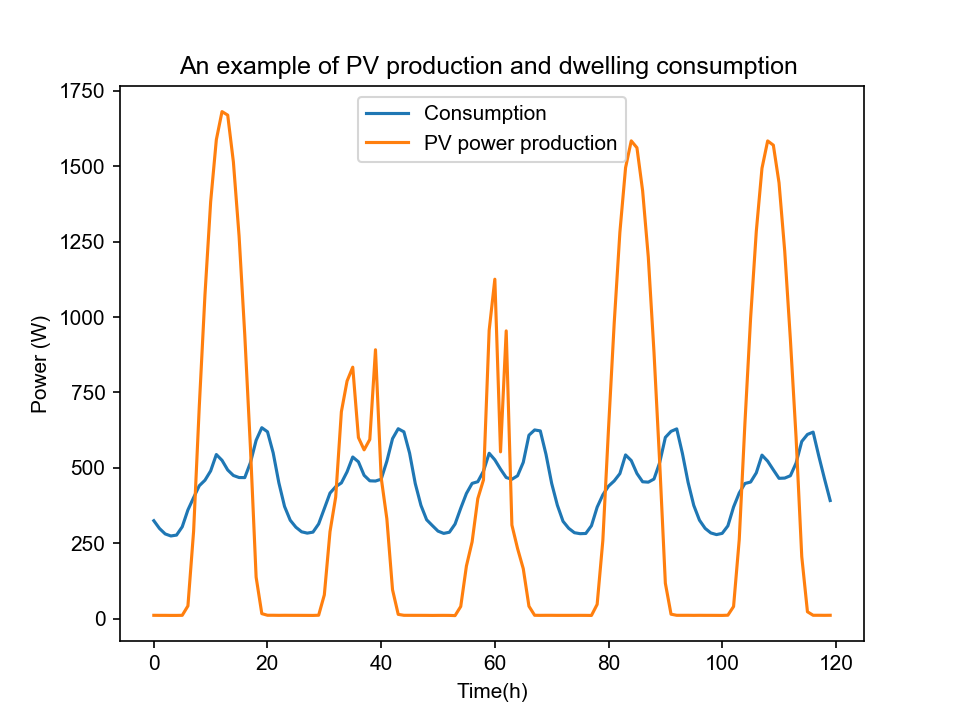

In [7]:
# plot
fig3, ax3 = plt.subplots()  
ax3.plot(cons_values, label='Consumption') 
ax3.plot(pv_power_values, label='PV power production') 
ax3.set_xlabel('Time(h)')  
ax3.set_ylabel('Power (W)')  
ax3.set_title('An example of PV production and dwelling consumption ')
ax3.legend() 

## Storage parameters
The storage parameters can be adapted in the following part.

In [8]:
e_sto = 434
eff_sto_lead_acid = 0.75  # Charging and discharging storage efficiency for the lead acid battery
eff_sto_li_ion = 0.85  # Charging and discharging storage efficiency for the lithium-ion battery
dod_lead_acid = 0.5  # Depth of Discharge for the lead acid battery
dod_li_ion = 0.8  # Depth of Discharge for the lithium-ion battery
self_disch_lead_acid = 0.01  # A default self-discharge of 1% of stored energy losses per hour is considered

capa_bat = e_sto/dod_lead_acid
p_max_bat = capa_bat

In [9]:
# The maximal power values of the grid are chosen based on the maximal consumption and PV production values
max_grid_sizing = (max(max(pv_power_values), max(cons_values)))*2  

## OMEGAlpes model building
Based on the previous parameters, an OMEGAlpes model can be built. Energy units such as consumption units for the pv pannels or storage units for the battery are created, and linked through energy nodes that ensure the power balance. Objectives are then added.  
A model of the MILP optimisation problem is then automatically generated, and solved through the PuLP Python package using the CBC solver as its default. Other solvers can be used with PuLP to improve the solving performances.

<img class="OMEGAlpes_PV"
     src="https://gricad-gitlab.univ-grenoble-alpes.fr/omegalpes/omegalpes_examples/-/raw/master/notebooks/figures/dwelling_pv_self_cons_omegalpes.png"
     alt="Dwelling PV self-consumption diagram">

In [10]:
# ENERGY UNITS
power_grid = ReversibleUnit(time=time, name="power_grid", pmax_cons=max_grid_sizing, 
                            pmax_prod=max_grid_sizing, 
                            energy_type_prod='Electrical', energy_type_cons=elec)

pv_pannels = FixedProductionUnit(time=time, name='PV_pannels', p=pv_power_values.tolist(), energy_type=elec)

dwelling_consumption = FixedConsumptionUnit(time=time, name='dwelling_consumption', p=cons_values.tolist(), 
                                            energy_type=elec)

battery = StorageUnit(time=time, name="battery", pc_max=p_max_bat, pd_max=p_max_bat, capacity=capa_bat,
                      e_0=0, soc_min=0, soc_max=dod_lead_acid, eff_c=eff_sto_lead_acid, 
                      eff_d=eff_sto_lead_acid, self_disch_t=self_disch_lead_acid, energy_type=elec)

elec_node = EnergyNode(time, name="elec_node", energy_type=elec)

Creating the power_grid_prod.
Creating the power_grid_cons.
Creating the power_grid.
Creating the PV_pannels.
Creating the dwelling_consumption.
Creating the battery.
Creating the elec_node.


Regarding the choice of the objectives, we can simply minimise the grid imports, i.e. the `power_grid_consumption`. The imports could also be minimised the as well in order to maximise the consumption coverage through local PV energy. These two objectives are already available in OMEGAlpes.   
An additional objective can be added in order to minimise the storage losses, for the battery charging to occur at relevant timings. Battery losses include self discharge as well as charging and discharging losses:
$$ losses_{bat} = \sum_{time} dt*(self_{disch}*e_{sto}[t]+(P_{ch}[t]+P_{disch}[t])*(1-eff_{sto})) $$  
With:
- dt the time step (i.e. with 15 minutes time step, dt = 1/4)
- e_sto[t] the energy stored in the battery at time t
- self_disch the self-discharging rate of the battery
- P_ch[t] the charging power of the battery at time t
- P_disch[t] the discharging power of the battery at time t
- eff_sto the charging and discharging efficiency of the storage.  

**NB**: Only the battery losses are taken into account for this simple battery management example. One should note that considering battery cycling and Depth of Discharge is necessary to take into account the battery ageing. Such indicators should be considered in the optimisation formulation, especially for studies focusing on environmental or economical objectives. In OMEGAlpes, cycling of batteries can be optimised with parameters such as min_time_on

In [11]:
# OBJECTIVES
# Already available in OMEGAlpes
power_grid.production_unit.minimize_production()
# power_grid.consumption_unit.minimize_consumption()

# Objective developped specifically here
battery.mininimize_losses = Objective(exp='lpSum({3}*({0}_e[t]*{1}+ '
                                   '({0}_pc[t]+{0}_pd[t])*(1-{2}))'
                                   ' for t in time.I)'.format(
    battery.name, self_disch_lead_acid,  eff_sto_lead_acid, time.DT),
    name='min_losses', active=True, unit='Wh', pareto=False, parent=None)

# UNITS CONNECTION TO ENERGY NODE
elec_node.connect_units(pv_pannels, dwelling_consumption, battery, power_grid.production_unit, 
                        power_grid.consumption_unit)

# MODEL BUILT AND RUN
model = OptimisationModel(time, name="ORUCE")
model.add_nodes(elec_node)

model.solve_and_update()



--- Adding all variables to the model ---
Adding variable : PV_pannels_p
Adding variable : PV_pannels_e_tot
Adding variable : dwelling_consumption_p
Adding variable : dwelling_consumption_e_tot
Adding variable : battery_p
Adding variable : battery_e_tot
Adding variable : battery_u
Adding variable : battery_capacity
Adding variable : battery_e
Adding variable : battery_pc
Adding variable : battery_pd
Adding variable : battery_uc
Adding variable : battery_e_f
Adding variable : power_grid_prod_p
Adding variable : power_grid_prod_e_tot
Adding variable : power_grid_prod_u
Adding variable : power_grid_cons_p
Adding variable : power_grid_cons_e_tot
Adding variable : power_grid_cons_u

--- Adding all objectives to the model ---
Adding objective : battery_min_losses
Adding objective : power_grid_prod_min_production

--- Adding all constraints to the model ---
Adding constraint : elec_node_power_balance , exp = PV_pannels_p[t]-dwelling_consumption_p[t]-battery_p[t]+power_grid_prod_p[t]-power_gr

## Results
The results indicators presented here are the dwelling consumption and PV production in kWh, compared with the power grid energy. We aslo calculate and display the Load Cover Factor and Supply Cover Factor, as defined by *Salomet al., 2014. « Analysis Of Load Match and Grid Interaction Indicators in NZEB with High-Resolution Data ». IEA Solar Heating and Cooling Programme.* https://doi.org/10.18777/ieashc-task40-2014-0001.

They obviously can be discussed and improved depending on the study objectives.

In [12]:
print('Total dwelling consumption = {} kWh'.format(round(dwelling_consumption.e_tot.get_value()/1000,2)))
# Problème de porucentage car pertes batteries pour le PV ! 
print('...coming from the power grid: {}%'.format(round(power_grid.production_unit.e_tot.
                                                        get_value()/dwelling_consumption.e_tot.get_value()*100)))
print('Total PV production  = {} kWh'.format(round(pv_pannels.e_tot.get_value()/1000,2)))
# batterie comprise ou consommée par le dwelling?
print('... locally consumed: {}%'.format(round((pv_pannels.e_tot.get_value()-power_grid.consumption_unit.e_tot.get_value())/pv_pannels.e_tot.get_value()*100)))
print('... injected on the grid: {}%'.format(round(power_grid.consumption_unit.e_tot.get_value()/pv_pannels.e_tot.get_value()*100)))
print('Supply Cover Factor: {}'.format(round((pv_pannels.e_tot.get_value()-power_grid.consumption_unit.e_tot.get_value())/pv_pannels.e_tot.get_value(),2)))
print('Load Cover Factor: {}'.format(round((dwelling_consumption.e_tot.get_value()-power_grid.production_unit.e_tot.get_value())/dwelling_consumption.e_tot.get_value(),2)))

Total dwelling consumption = 53.21 kWh
...coming from the power grid: 48%
Total PV production  = 50.07 kWh
... locally consumed: 57%
... injected on the grid: 43%
Supply Cover Factor: 0.57
Load Cover Factor: 0.52


<IPython.core.display.Javascript object>


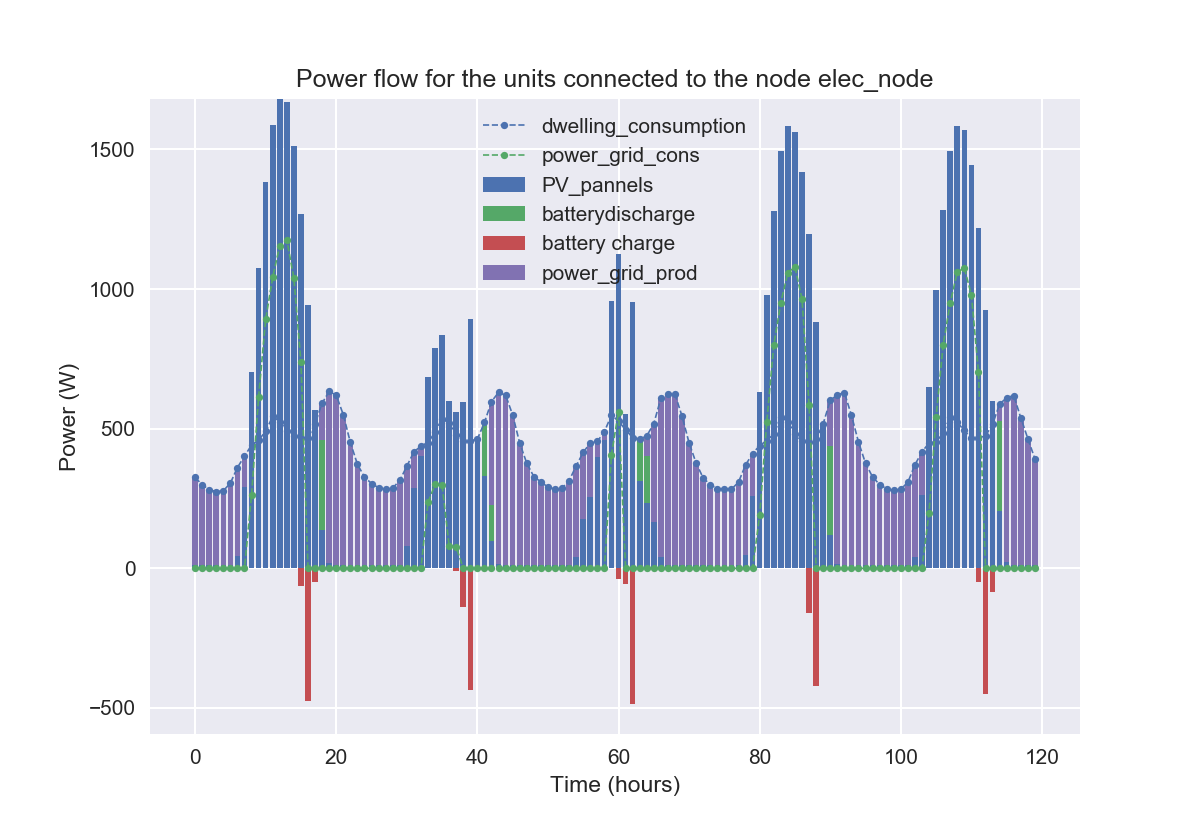


Preparing to plot the energetic flows through the node elec_node.
	Add power from PV_pannels.
	Add power from dwelling_consumption.
	Add power from battery.
	Add power from power_grid_prod.
	Add power from power_grid_cons.


In [13]:
plt = plot_node_energetic_flows(elec_node)
plt.ylabel("Power (W)")  # changing label from default (kW) to W
plt.show()

In this case, the results regarding the battery management is quite trivial but it enables to see the power flows for the studied time period. The OMEGAlpes model is accessible for more intricate studies on this energy system.

Finally, the energy flows can be saved as csv files.

In [14]:
save_energy_flows(elec_node, sep=';', file_name='results/ORUCE_PV_results')

## Discussion

Other approaches could be considered in this study. Part of the power demand could be managed to reflect a possible adaptation of consumption to local production. Future work could also include a battery management depending on dynamic CO2 power grid GHG emissions. It would also be interesting to carry out the study at the neighbourhood scale in order to qualify and quantify the consequences on the energy networks, to evaluate the relevance of the sizing with the indicators presented here.  
One perspective envisaged is to extend this case study to the scale of collective self-consumption operations in order to integrate energy community issues. A particular point of interest is the empowerment of the local energy communities, with the emergence of a “sharing economy” in which idle resources as well as digital and material commons are identified and used in mutual ways (Kostakis et al. 2015 - DOI: 10.1016/j.jclepro.2016.09.077). This enables communities to manage directly and autonomously each resource at their disposal, potentially leading to virtuous behavioural responses, such as reduced energy use or load shifting. 

<a id='factsheet'></a>
## Factsheet
Notebook factsheet based on the [OEP scenario factsheet](https://openenergy-platform.org/factsheets/scenarios/)

<style type="text/css">
	table.tableizer-table {
		font-size: 12px;
		border: 1px solid #CCC; 
		font-family: Arial, Helvetica, sans-serif;
	} 
	.tableizer-table td {
		padding: 4px;
		margin: 3px;
		border: 1px solid #CCC;
	}
	.tableizer-table th {
		background-color: #104E8B; 
		color: #FFF;
		font-weight: bold;
	}
</style>
<table class="tableizer-table">
 <tr><td rowspan=21>Study</td>
 <tr><td>&nbsp;</td><td>Name</td><td>A dwelling photovoltaic self-consumption example</td></tr>
 <tr><td>&nbsp;</td><td>Author - institution</td><td>Sacha Hodencq - G2Elab</td></tr>
 <tr><td>&nbsp;</td><td>Contact</td><td>sacha.hodencq@g2elab.grenoble-inp.fr</td></tr>
 <tr><td>&nbsp;</td><td>Client</td><td>None</td></tr>
 <tr><td>&nbsp;</td><td>Funding</td><td>Public</td></tr>
 <tr><td>&nbsp;</td><td>Citation reference</td><td>S. Hodencq, B. Delinchant, and F. Wurtz, ‘Open and Reproducible Use Cases for Energy (ORUCE) methodology in systems design and operation: a dwelling photovoltaic self-consumption example’, Bruges, Belgium, Sep. 2021. Accessed: Sep. 16, 2021. [Online]. Available: https://hal.archives-ouvertes.fr/hal-03341883</td></tr>
 <tr><td>&nbsp;</td><td>Aim</td><td>The study is twofold: first, maximising both the coverage of local consumption by photovoltaic electricity and minimising the environmental impact of the energy system over its entire life cycle. Then, an optimal power flows management is applied to the obtained energy system design</td></tr>
 <tr><td>&nbsp;</td><td>New aspects</td><td>Open energy workflow based on a use case at building scale (see ORUCE in the article) ; proposing a Pareto between self-consumption system GWP and Load Cover Factor</td></tr>
 <tr><td>&nbsp;</td><td>Spatial / Geographical coverage</td><td>Buidling - district scale ; Grenoble</td></tr>
 <tr><td>&nbsp;</td><td>Time frame</td><td>2019</td></tr>
 <tr><td>&nbsp;</td><td>Tools</td><td>OMEGAlpes ; NoLOAD</td></tr>
 <tr><td>&nbsp;</td><td>Modeled energy sectors</td><td>Electricity</td></tr>
 <tr><td>&nbsp;</td><td>Modeled demand sectors</td><td>Households</td></tr>
 <tr><td>&nbsp;</td><td>Economic (behavioural) rationale </td><td>Single fictive decision-maker with perfect knowledge (perfect foresight optimization)</td></tr>
 <tr><td>&nbsp;</td><td>Technologies included </td><td>mono-cristalline PV, lead-acid batteries, Electricity</td></tr>
 <tr><td>&nbsp;</td><td>Economic focuses included</td><td>No</td></tr>
 <tr><td>&nbsp;</td><td>Social focuses included</td><td>No</td></tr>
 <tr><td>&nbsp;</td><td>Endogenous variables</td><td>PV power, Grid power, Battery charging and discharging power, battery energy and capacity</td></tr>
 <tr><td>&nbsp;</td><td>Time steps</td><td>Hour</td></tr>
 <tr><td rowspan=7>Empirical data</td>
 <tr><td>&nbsp;</td><td>Exogenous time series used</td><td>Load curves, Irradiances</td></tr>
 <tr><td>&nbsp;</td><td>Technical data + usage</td><td>Grenoble Diffuse Horizontal Irradiance & Direct Normal Irradiance in 2019, French mean electrical dwelling consumption ; PV and batteries technical characteristics</td></tr>
 <tr><td>&nbsp;</td><td>Social data</td><td>None</td></tr>
 <tr><td>&nbsp;</td><td>Economical data</td><td>None</td></tr>
 <tr><td>&nbsp;</td><td>Ecological data</td><td>Static mean european power grid GHG emissions ; PV and batteries GWP</td></tr>
    <tr><td>&nbsp;</td><td>Pre-Processing</td><td>Clustering, see <a href="https://gricad-gitlab.univ-grenoble-alpes.fr/design_optimization/noload_benchmarks_open/-/blob/master/examples/pv_battery_coverage_gwp/pv_battery_coverage_gwp.ipynb">NoLOAD notebook</a></td></tr>
 <tr><td rowspan=5>Assumptions</td>
<tr><td>&nbsp;</td><td>Energy assumption</td><td>Mean consumption of a French dwelling, based on Enedis (French DSO), 
<a href="https://www.enedis.fr/coefficients-des-profils">RES1 profile</a> i.e. consumption profiles for dwellings connected in low-voltage with nominal power lower than 6 kVA. We consider an annual consumption of 4453 kWh per year and per dwelling, when applying an annual consumption of 4586 KWh to the RES1 profiles. This consumption is    calculated from the number of households connected to the French power system according to this <a href="https://www.cre.fr/Documents/Publications/Rapports-thematiques/Etat-des-lieux-des-marches-de-detail-de-l-electricite-et-du-gaz-naturel-en-2017">French Energy Regulatory Commission (CRE) report</a>, page 19 (32.4 million connected residential consumers in 2017), and the final electricity consumption of the French residential sector of <a href="https://opendata.reseaux-energies.fr/explore/dataset/consommation-annuelle-nette-typologie/table/?disjunctive.segment&sort=annee"> 148.6 TWh in 2019</a>.
</td></tr>
 <tr><td>&nbsp;</td><td>Environmental assumptions</td><td>Considering european power grid emissions (source: <a href="https://www.eea.europa.eu/data-and-maps/daviz/co2-emission-intensity-5#tab-googlechartid_chart_11_filters=%7B%22rowFilters%22%3A%7B%7D%3B%22columnFilters%22%3A%7B%22pre_config_ugeo%22%3A%5B%22European%20Union%20(current%20composition%22%5D%7D%7D)">EEA website</a> ), and PV and batteries GWP based on the following sources <a href="https://www.base-inies.fr/iniesV4/dist/consultation.html?id=8519">mono-cristalline PV</a> <a href="https://www.base-inies.fr/iniesV4/dist/consultation.html?id=5638">lead-acid battery</a></td></tr>
 <tr><td>&nbsp;</td><td>Economic assumption</td><td>None</td></tr> 
 <tr><td>&nbsp;</td><td>Post-processing</td><td>In the NoLOAD study (Pareto between GWP and non-LCF), only a static value for the stored energy is considered for each typical day. To get the battery capacity value, the maximal stored energy between typical days is multplied by the considered Depth of Discharge of the batteries. </td></tr> 
 <tr><td rowspan=5>Results</td>
 <tr><td>&nbsp;</td><td>Uncertainty assesment</td><td>No uncertainty analysis has been carried out in this study. A particular attention should be given to the GWP values of PV and batteries that are really uncertain: the GWP indicator for monocrystalline PV panels alone, the differences between the values from different reliable sources exceed a factor of 3. In addition to the fact that the calculation of GHG emissions from photovoltaic modules depends on a large number of factors, this variability can be explained on the one hand by whether or not connectors and inverters are taken into account in the impact calculation, and on the other hand by the origin of the PV panels, as pointed out by Yue et al [doi: 10.1016/j.solener.2014.04.008]. In this respect, the initiative of the BONSAI project (bonsai.uno) to deploy an open database for LCA data is very relevant and promising.</td></tr>
 <tr><td>&nbsp;</td><td>Robustness</td><td>MILP optimisations lead with OMEGAlpes are robust and reproducible, while SQP optimisation lead with NoLOAD can have convergence issues, depending on the iteration number and precision. If any issue is met with these tools, please indicate them in the Issues section of their gitlab.</td></tr>
 <tr><td>&nbsp;</td><td>Comparability / Validation</td><td>The energy model as well as LCF and SCF consideration are close to widespread research work (see Salom et al. - DOI: 10.18777/ieashc-task40-2014-0001). The use of clustering techniques is a method adapted to the reduction of the study period and therefore of the number of variables for energy optimisation on a building scale (see Sayegh et al. - DOI: 10.26868/25222708.2019.210214). Further analysis and comparison are needed to exploit results and assess their relevance. </td></tr>
 <tr><td>&nbsp;</td><td>Conclusions</td><td>One should not deduce general conclusions out of the simplififed study case presented here, since a lot of assumptions are made and uncertain values are used. The aim of the study is to underline the importance of considering LCA indicators for energy system analysis, and to do so in an open energy modelling process. The study provides simple models for adapting the case study to different situations, e.g. by varying the battery or PV panel technologies, or selecting input data depending on the new study characteristics and taking into account uncertainties. It also enables to benchmark different energy models, methods of study period or model reduction, and optimisation techniques. </td></tr>
</tbody></table>